In [243]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (15,10)
plt.style.use('seaborn')

In [244]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))
hf.close()

In [245]:
time = data[0,:]
solar_phase = data[1,:]
earth_long = data[2,:]
part_count = data[3,:]

### Problem 1

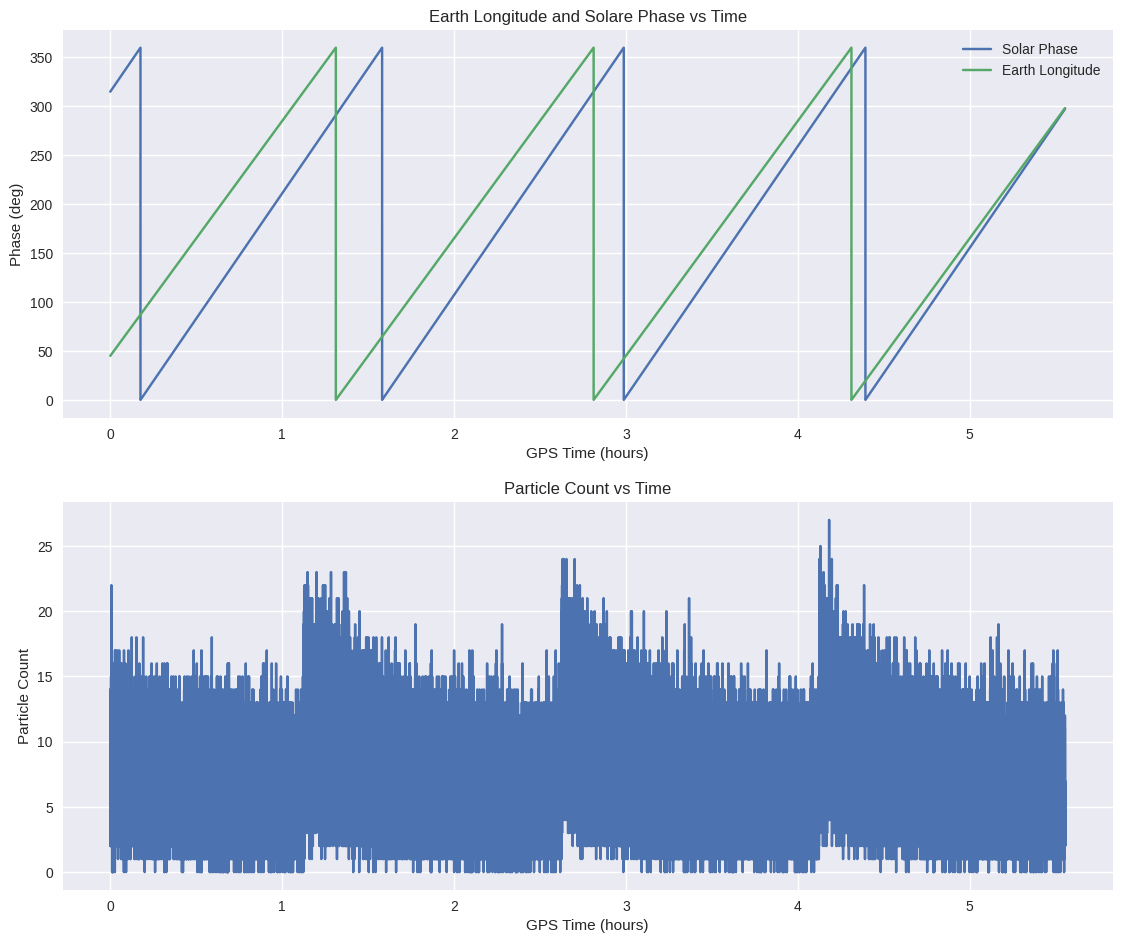

In [246]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4)

time_fix = time - data[0,0]
time_hours = time_fix / 60 / 60
time_mins = time_fix / 60

ax[0].plot(time_hours[0:200000], solar_phase[0:200000], label="Solar Phase")
ax[0].plot(time_hours[0:200000], earth_long[0:200000], label="Earth Longitude")
ax[0].set_xlabel("GPS Time (hours)")
ax[0].set_ylabel("Phase (deg)")
ax[0].legend(loc=0)
ax[0].set_title("Earth Longitude and Solare Phase vs Time")

ax[1].plot(time_hours[0:200000], part_count[0:200000])
ax[1].set_xlabel("GPS Time (hours)")
ax[1].set_ylabel("Particle Count")
ax[1].set_title("Particle Count vs Time")

plt.show()

Data features:
- Earth longitude has a slightly longer period than solar phase (the Earth spins as the satellite orbits)
- Particle count oscilates over time with a similar frequency as Earth Longitude or solar phase (difficult to immediately tell), implying a relation to one of those variables

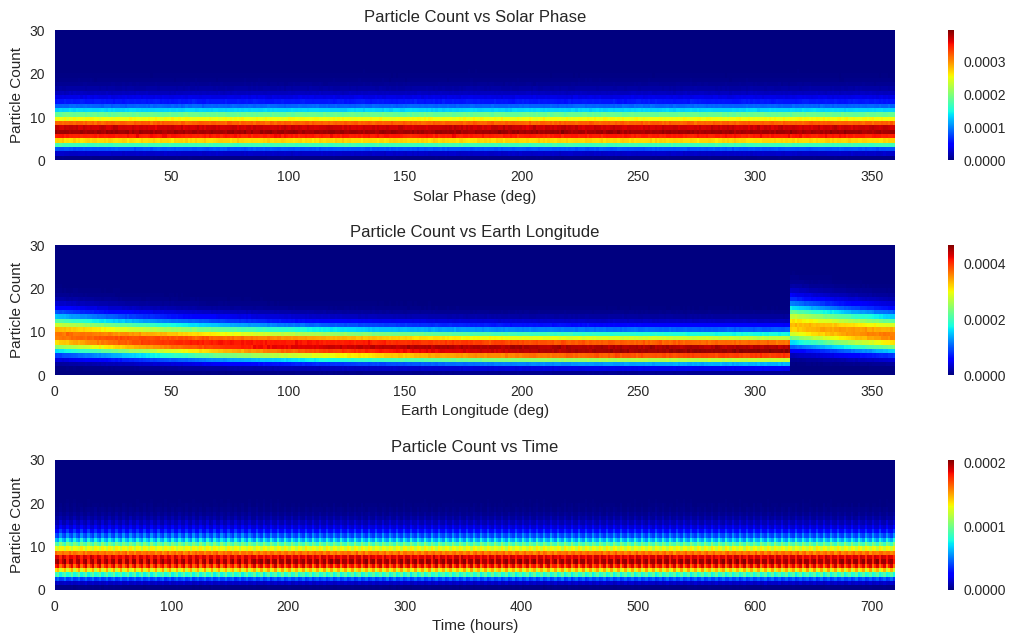

In [247]:
fig, ax = plt.subplots(3,1, figsize=(12,7))
fig.tight_layout(pad=4)

g = ax[0].hist2d(solar_phase, part_count, bins=(360, 30), cmap=plt.cm.jet, density=True)
ax[0].set_xlabel("Solar Phase (deg)")
ax[0].set_ylabel("Particle Count")
ax[0].set_title("Particle Count vs Solar Phase")
plt.colorbar(g[3], ax=ax[0])

h = ax[1].hist2d(earth_long, part_count, bins=(360, 30), cmap=plt.cm.jet, density=True)
ax[1].set_xlabel("Earth Longitude (deg)")
ax[1].set_ylabel("Particle Count")
ax[1].set_title("Particle Count vs Earth Longitude")
plt.colorbar(h[3], ax=ax[1])

i = ax[2].hist2d(time_hours, part_count, bins=(360, 30), cmap=plt.cm.jet, density=True)
ax[2].set_xlabel("Time (hours)")
ax[2].set_ylabel("Particle Count")
ax[2].set_title("Particle Count vs Time")
plt.colorbar(i[3], ax=ax[2])

plt.show()

Data features:
- Particle count (background) does not depend on solar phase or time, but it does depend on earth longitude

To find the background, we need to examine the particle count distribution at each point. Since particle count appears to depend on Earth longitude, we split the 2D histogram (above plot) into discreet bins for each degree. Then, at each degree, we can plot the probability of detecting the number of particles.

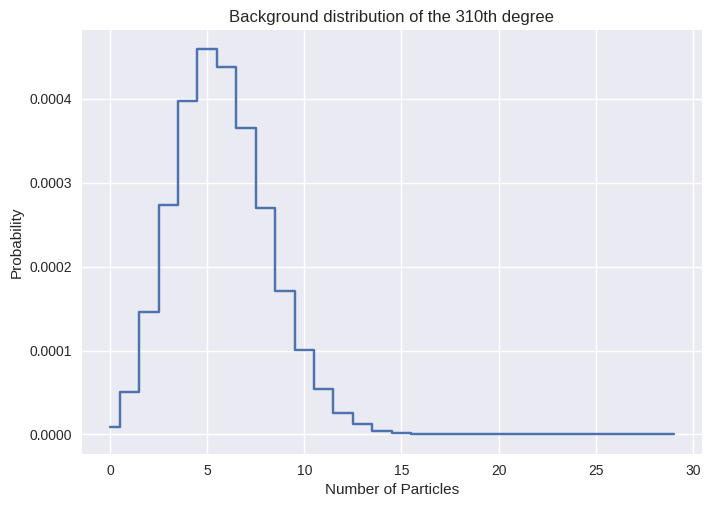

In [248]:
fig, ax = plt.subplots(1,1)

x = np.arange(0, part_count.max(), 1)
ax.step(x, h[0][310], where='mid')

plt.xlabel("Number of Particles")
plt.ylabel("Probability")
plt.title("Background distribution of the 310th degree")
plt.show()

The above plot shows the probability distribution -- a Poisson -- of the background at a given degree of Earth longitude. From this data, we can calculate the mean as a function of degree.

In [249]:
g = h

means = []
for i in range(len(g[1])-1):
    g[0][i] = g[0][i] / np.sum(g[0][i])
    av = 0
    for n in range(len(g[0][i])-1):
        av = av + (g[0][i][n] * n)
    means.append(av)
    
index = 0
for i in range(len(means) - 1):
    if(means[i] >= max(means)):
        index = i
        break
        
shifted_means = means[0:index]
for i in range(len(h[1]) - index):
    shifted_means = np.insert(shifted_means, 0, means[-i])

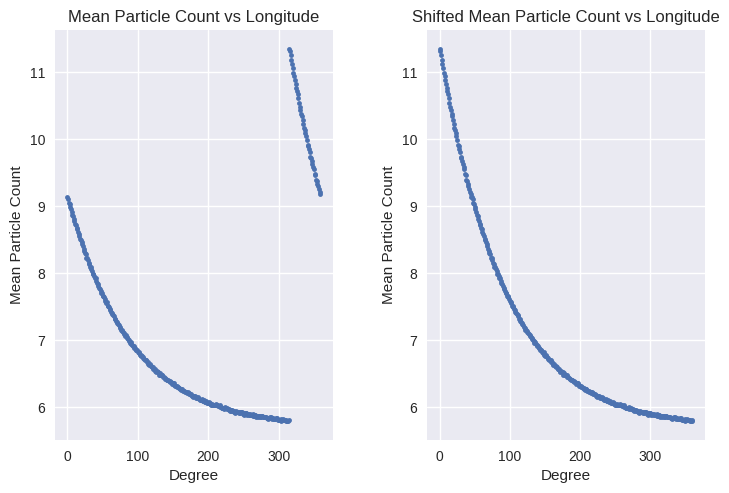

In [250]:
fig, ax = plt.subplots(1,2)
fig.tight_layout(pad=4)

deg = np.arange(0, 361, 1)

ax[1].plot(deg, shifted_means, '.')
ax[1].set_title("Shifted Mean Particle Count vs Longitude")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Mean Particle Count")

ax[0].plot(deg[0:360], means, '.')
ax[0].set_title("Mean Particle Count vs Longitude")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Mean Particle Count")

plt.show()

The mean particle count as a function of Earth longitude can be seen in the plot above. There is a jump at the 315th degree, so the data can be shifted to make a more continuous function. In order to develop a truly continuous model of mean as a function of degree, we fit an exponential curve to the above data.

In [251]:
def fit(x, a, b, c, d):
    return a*np.exp(b*(x+c)) + d

guess_a = 11
guess_b = -0.01
guess_c = -10              
guess_d = 10

init_guesses = [guess_a, guess_b, guess_c, guess_d]

In [252]:
fitpars, error = curve_fit(fit,
                          deg, shifted_means,
                          init_guesses)

print(fitpars)

[ 1.74826549e+01 -1.09500085e-02  1.02914574e+02  5.68967182e+00]


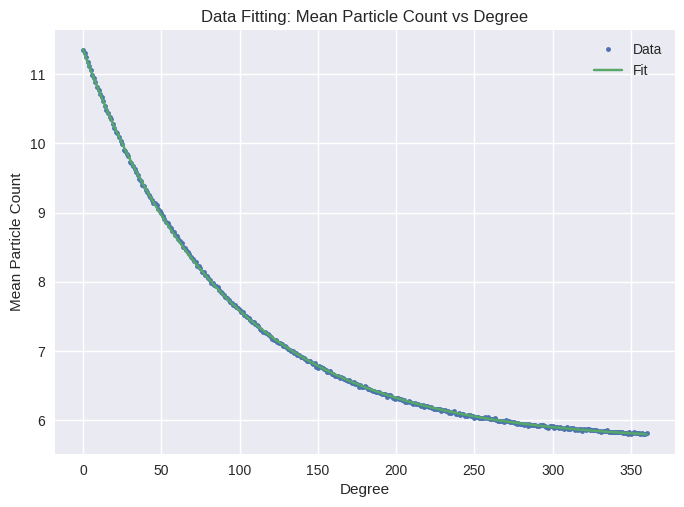

In [253]:
fig, ax = plt.subplots(1,1)

x = deg
y = shifted_means

ax.plot(x, y, '.', label='Data')
ax.plot(x, fit(x, *fitpars), label='Fit')

plt.xlabel("Degree")
plt.ylabel("Mean Particle Count")
plt.title("Data Fitting: Mean Particle Count vs Degree")

plt.legend(loc=0)
plt.show()

#### Model: 
The above function can be fit with the equation:
$
\large
\lambda(x) = 6.74e^{-0.011(x+15.8))} + 5.69
$
, where $x$ is the longitudinal degree. The next step is to find $\lambda$ at a given time; this can be accomplished by matching time to degree in the data table provided. 

In [254]:
# time in minutes

def find_lambda(t_min):
    time_index = np.where(time_mins == t_min)
    degree = earth_long[time_index][0]
    lambda_value = fitpars[0]*np.exp(fitpars[1]*(degree+fitpars[2])) + fitpars[3]
    return degree, lambda_value

In [255]:
t = 30
degree_1 = find_lambda(t)[0]
lambda_value_1 = find_lambda(t)[1]

print("At "+str(t)+" minutes, the satellite is at "+str(degree_1)+" degrees of longitude.")
print("This corresponds to a background Poisson with a mean of "+str(round(lambda_value_1,2))+".")

At 30 minutes, the satellite is at 165.0 degrees of longitude.
This corresponds to a background Poisson with a mean of 6.62.


In [256]:
t = 45
degree_2 = find_lambda(t)[0]
lambda_value_2 = find_lambda(t)[1]

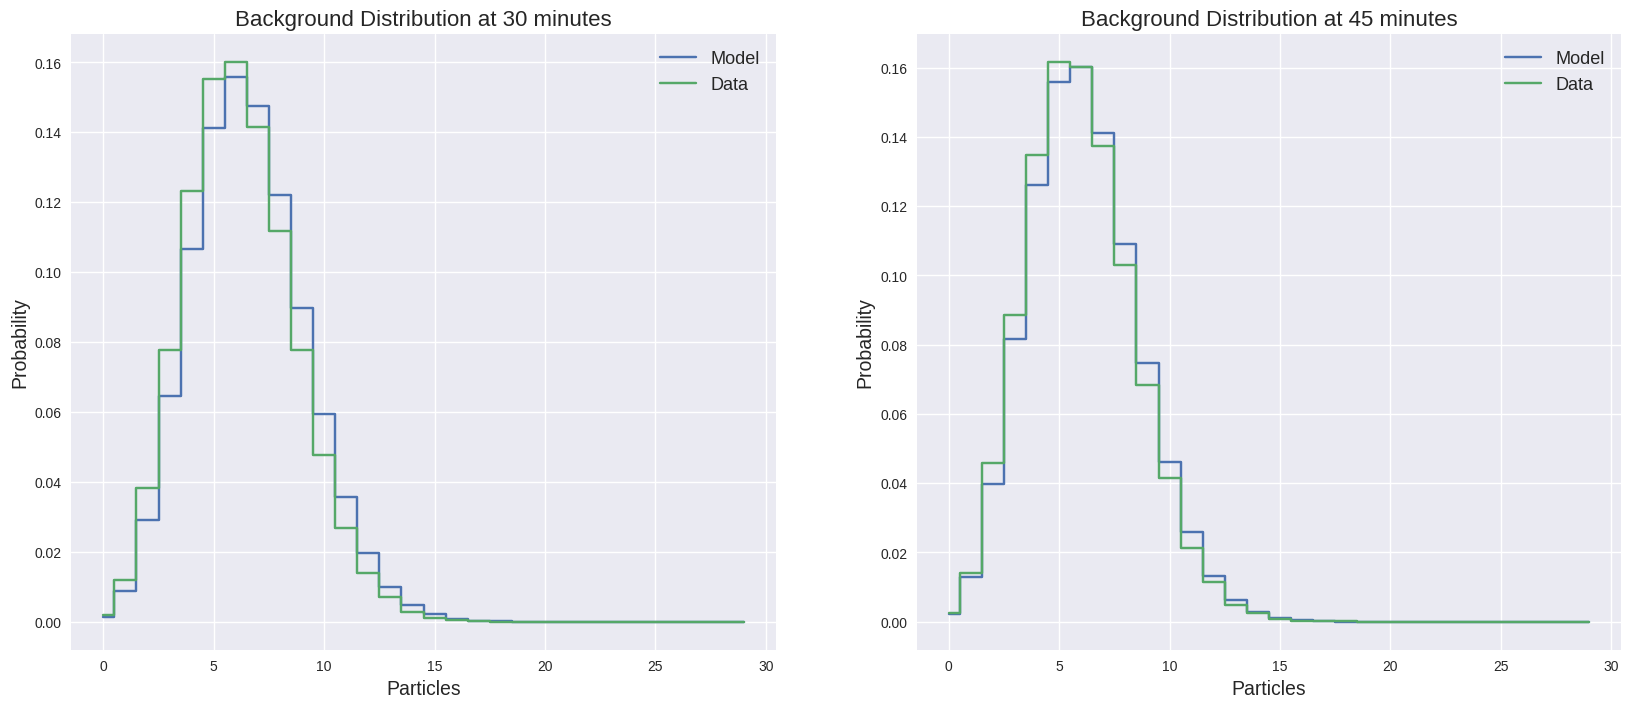

In [257]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

x = np.arange(0, 30, 1)

y_1 = stats.poisson.pmf(x, lambda_value_1)
ax[0].step(x, y_1, where='mid', label='Model')
ax[0].step(x, h[0][int(degree_1)], where='mid', label='Data')
ax[0].set_xlabel("Particles", fontsize=14)
ax[0].set_ylabel("Probability", fontsize=14)
ax[0].set_title("Background Distribution at 30 minutes", fontsize=16)

y_2 = stats.poisson.pmf(x, lambda_value_2)
ax[1].step(x, y_2, where='mid', label='Model')
ax[1].step(x, h[0][int(degree_2)], where='mid', label='Data')
ax[1].set_xlabel("Particles", fontsize=14)
ax[1].set_ylabel("Probability", fontsize=14)
ax[1].set_title("Background Distribution at 45 minutes", fontsize=16)

ax[0].legend(loc=0, fontsize=13)
ax[1].legend(loc=0, fontsize=13)

plt.show()

The model isn't a perfect fit, but approximates the background distribution of the data. From the models, we can determine the measurement values needed to be statistically significant at various times.

In [258]:
prob5sigma = stats.norm.cdf(5, loc=0, scale=1)

measurement_val_1 = stats.poisson.ppf(prob5sigma, lambda_value_1, loc=0)
measurement_val_2 = stats.poisson.ppf(prob5sigma, lambda_value_2, loc=0)

print("To be significant at 30 minutes, a measurement of "+str(measurement_val_1)+" is needed\n" 
      "To be significant at 45 minutes, a measurement of "+str(measurement_val_2)+" is needed.")

To be significant at 30 minutes, a measurement of 23.0 is needed
To be significant at 45 minutes, a measurement of 22.0 is needed.


### Problem 2

In [259]:
import h5py
import numpy as np
import io
from PIL import Image

hf = h5py.File('images.h5', 'r')
print(hf.keys())

image1 = hf['image1']
imagestack = hf['imagestack']
print(imagestack.shape)

<KeysViewHDF5 ['image1', 'imagestack']>
(200, 200, 10)


To find the background, I first picked a range of the image where there were no apparent stars (75 pixels in the 2nd row from the top). I calculated the mean and standard deviation of this data set, and assumed any cause of background variation to be Gaussian. The background looks different from my partner's because we used different regions to calibrate 'blank space'.

In [260]:
background = image1[2][0:75]

b_min = background.min()
b_max = background.max()
index_min = np.where(background==b_min)
index_max = np.where(background==b_max)

mean = np.mean(background)
std = np.std(background)

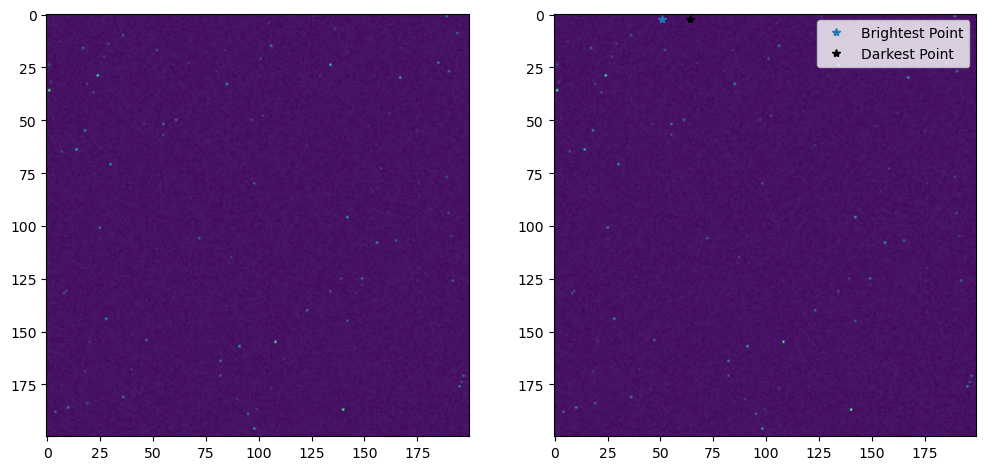

In [261]:
plt.style.use('default')
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(image1)
ax[1].imshow(image1)
ax[1].plot(index_max, 2, '*', label='Brightest Point')
ax[1].plot(index_min, 2, 'k*', label="Darkest Point")
ax[1].legend(loc=0)

plt.show()

In [ ]:
The plot on the left shows the entire image, and the plot on the rig

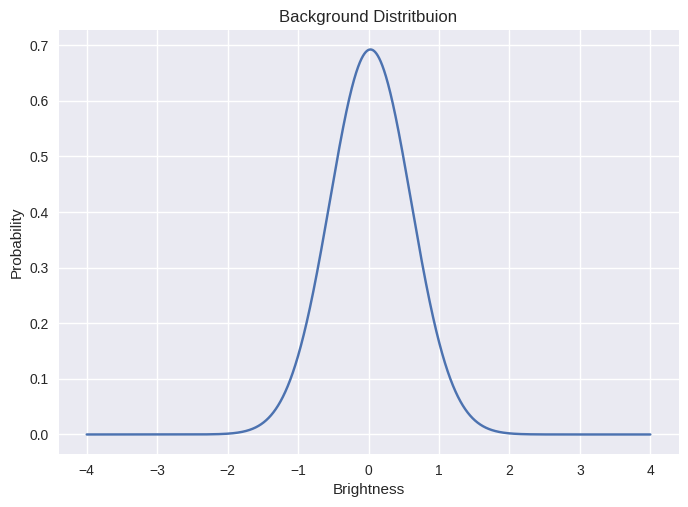

In [262]:
x = np.linspace(-4, 4, 10000)
bkg = stats.norm.pdf(x, loc=mean, scale=std)

plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)

ax.plot(x, bkg)
ax.set_xlabel("Brightness")
ax.set_ylabel("Probability")
ax.set_title("Background Distritbuion")
plt.show()

Once the background was determined, it could be subtracted from the images and the faintest stars detected. The faintest star in each plot of "imagestack" is shown below, along with its value and coordinates.

In [263]:
threshold = b_max

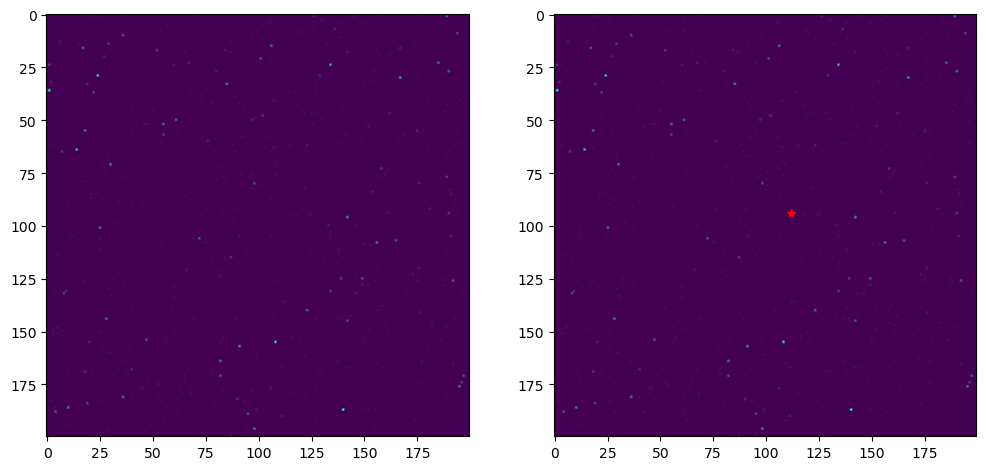

1.20564527030135 (array([112]), array([94]))


In [282]:
plt.style.use('default')

h = imagestack[:,:,0]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()

print(minval, index)

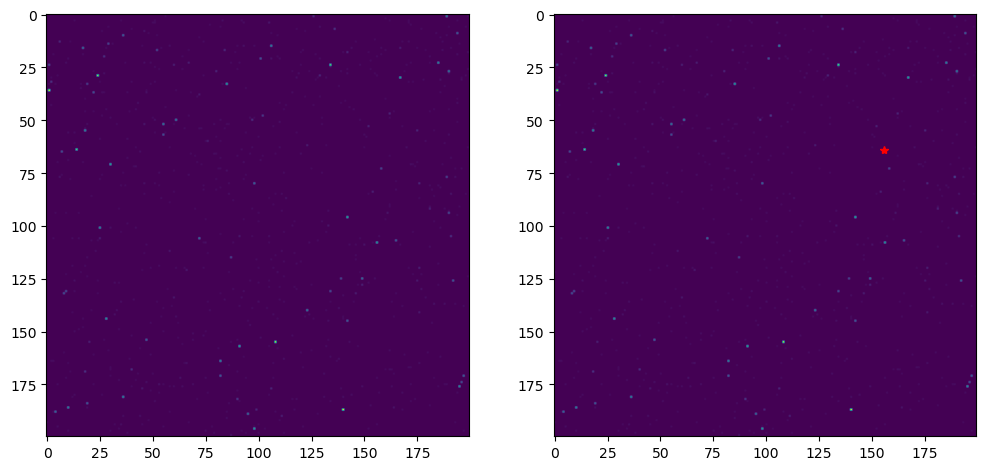

1.2065473917374814 (array([156]), array([64]))


In [283]:
plt.style.use('default')

h = imagestack[:,:,1]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()

print(minval, index)

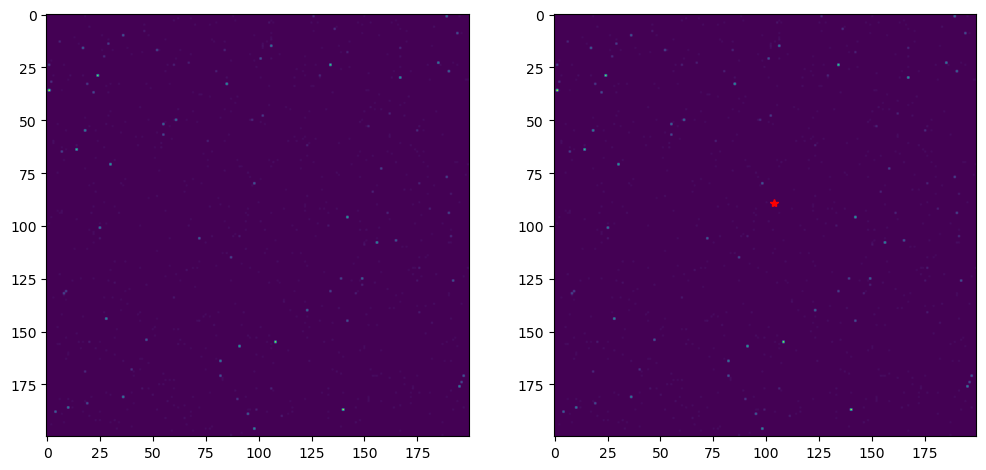

1.2055506173851824 (array([104]), array([89]))


In [284]:
plt.style.use('default')

h = imagestack[:,:,2]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()
print(minval, index)

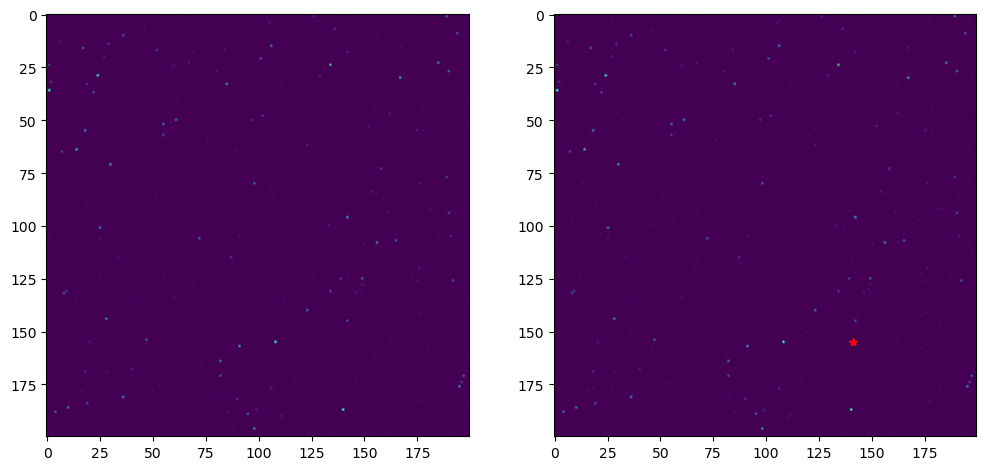

1.2057955741499728 (array([141]), array([155]))


In [285]:
plt.style.use('default')

h = imagestack[:,:,3]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()
print(minval, index)

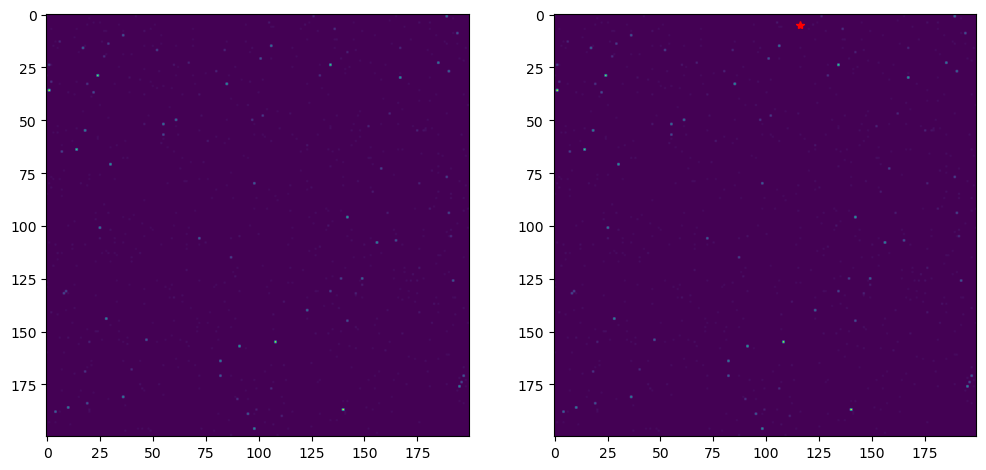

1.205855130472881 (array([116]), array([5]))


In [286]:
plt.style.use('default')

h = imagestack[:,:,4]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()
print(minval, index)

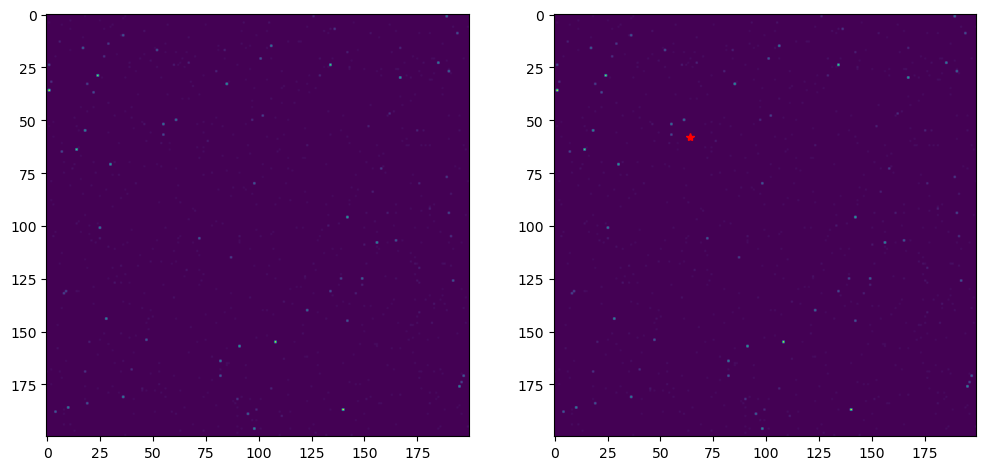

1.2054895544873523 (array([64]), array([58]))


In [287]:
plt.style.use('default')

h = imagestack[:,:,5]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()
print(minval, index)

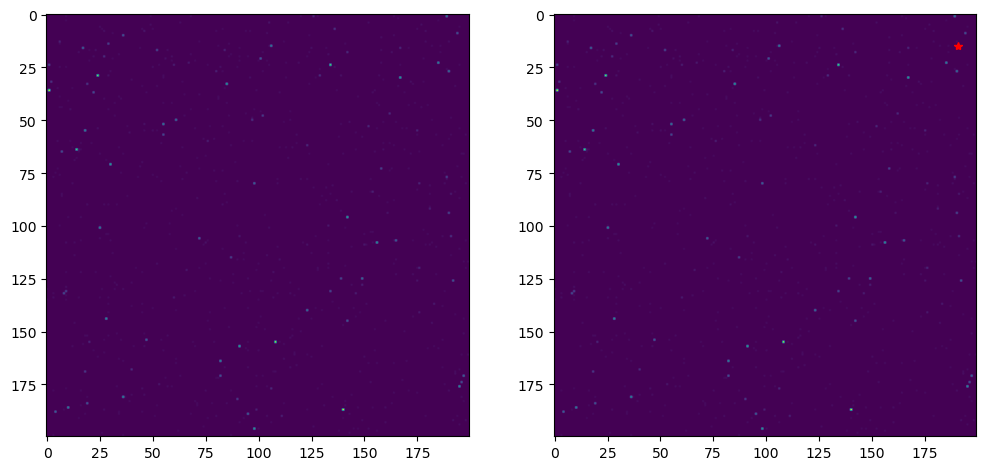

1.2060136277539082 (array([191]), array([15]))


In [288]:
plt.style.use('default')

h = imagestack[:,:,6]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()
print(minval, index)

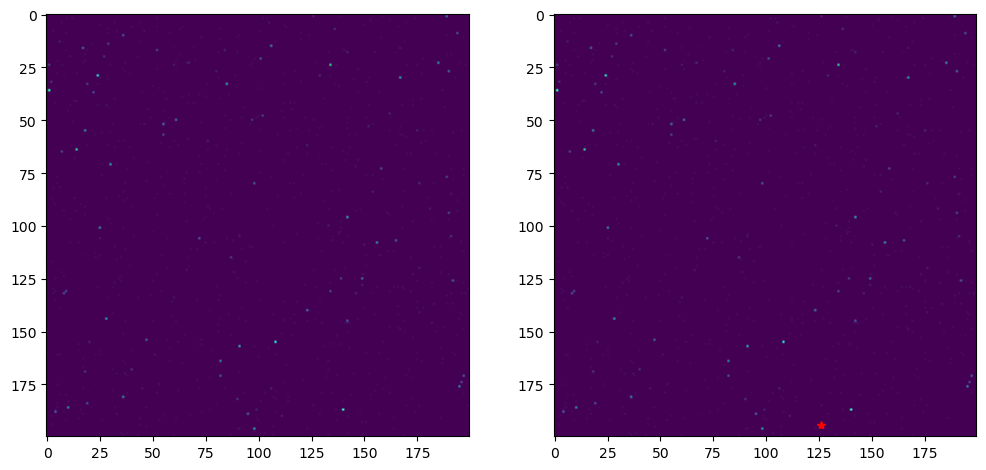

1.2062231407572557 (array([126]), array([194]))


In [289]:
plt.style.use('default')

h = imagestack[:,:,7]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()
print(minval, index)

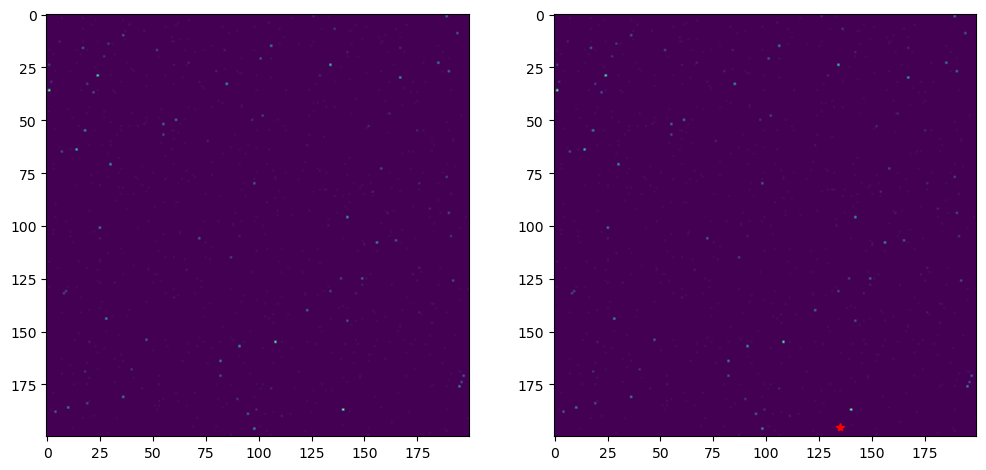

1.2055481751362112 (array([135]), array([195]))


In [290]:
plt.style.use('default')

h = imagestack[:,:,8]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()
print(minval, index)

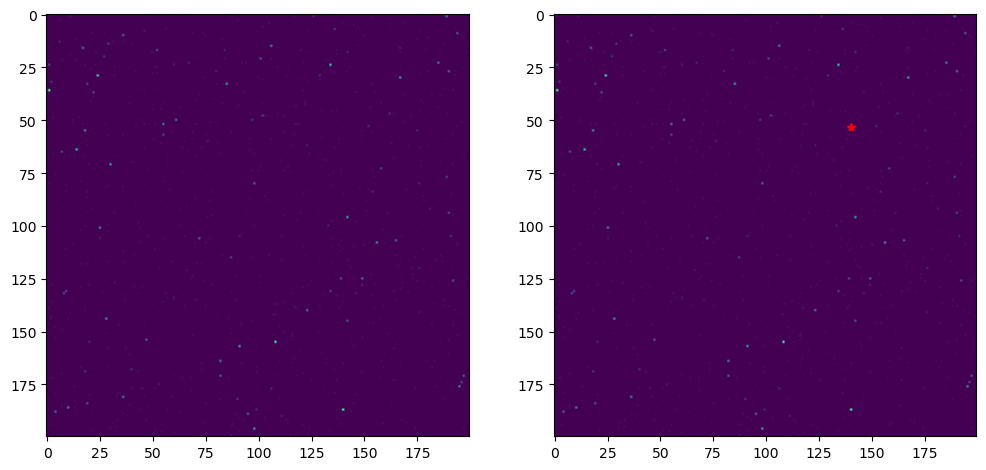

1.205501227365568 (array([140]), array([53]))


In [291]:
plt.style.use('default')

h = imagestack[:,:,9]
for j in range(len(h[0])):
    for k in range(len(h[0])):
        if h[j][k] < threshold:
            h[j][k] = 0
            
minval = np.min(h[np.nonzero(h)])
index=np.where(h==minval)

fig,ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(h)
ax[1].imshow(h)
ax[1].plot(index[0][0], index[1][0], 'r*')

plt.show()
print(minval, index)